It seems the data and the sync's fitting is so bad, finally I give it up. Maybe he has used his own sources. But I can produce some figures for the data.

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pyasdf
import obspy
from obspy.geodetics.base import gps2dist_azimuth,kilometer2degrees
from obspy.taup import TauPyModel

%matplotlib inline

model = TauPyModel(model="ak135")
from obspy.signal.util import _npts2nfft

In [46]:
def process_single_data_trace(net_sta,asdf_file):
    data=pyasdf.ASDFDataSet(asdf_file,mode="r")
    
    event = data.events[0]
    origin = event.preferred_origin() or event.origins[0]
    event_time = origin.time
    event_latitude = origin.latitude
    event_longitude = origin.longitude
    event_depth=origin.depth
    
    st=data.waveforms[net_sta].raw.copy()
    
    st.trim(event_time,event_time+1800)
    
    st.detrend("demean")
    st.detrend("linear")
    st.taper(max_percentage=0.05,type="hann")
    
    inv=data.waveforms[net_sta].StationXML
    
    max_period=100
    min_period=10
    f2 = 1.0 / max_period
    f3 = 1.0 / min_period
    f1 = 0.5 * f2
    f4 = 2.0 * f3
    pre_filt = (f1, f2, f3, f4)
    
    st.remove_response(output="DISP", pre_filt=pre_filt, zero_mean=False,
                               taper=False, inventory=inv, water_level=None)
    
    st.interpolate(sampling_rate=10)
    
    station_latitude = inv[0][0].latitude
    station_longitude = inv[0][0].longitude
    gcarc_m, baz, _ = gps2dist_azimuth(station_latitude, station_longitude,
                                             event_latitude, event_longitude)
    baz = np.mod(baz, 360)
    st.rotate(method="NE->RT", back_azimuth=baz)
    
    st.filter("bandpass",freqmin=1/100,freqmax=1/10,corners=2,zerophase=True)
    
    to_plot=st.slice(event_time+kilometer2degrees(gcarc_m/1000)*18+20,event_time+kilometer2degrees(gcarc_m/1000)*18+140)
#     to_plot=st.slice(event_time,event_time+600)
    
    return to_plot,kilometer2degrees(gcarc_m/1000)

In [4]:
asdf_file="/Users/ziyixi/work/Japan_Slab_code/data/asdf_files/compare_data_processing/201105101526A.data.h5"

In [8]:
net_sta_list=["BO.WJM","BO.SRN","BO.KNM","BO.TTO","BO.NAA","BO.FUJ","BO.KNY"]

4.92218310496e-06
1.94226931553e-06
1.12008693575e-06
1.08275120614e-06
7.40528645261e-07
8.66458926652e-07
8.20129528389e-07


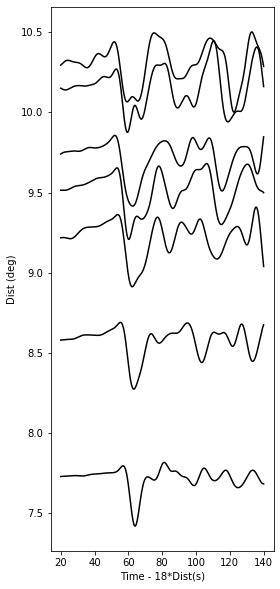

In [35]:
plt.figure(figsize=(4,10))
for net_sta in net_sta_list:
    to_plot,gcarc=process_single_data_trace(net_sta,asdf_file)
    to_plot=to_plot[0]
    print(np.max(to_plot.data))
    to_plot.normalize()
    x=np.linspace(20,to_plot.stats.endtime-to_plot.stats.starttime+20,to_plot.stats.npts)
    y=to_plot.data*(-0.3)+gcarc
    plt.plot(x,y,color="k")
    plt.xlabel("Time - 18*Dist(s)")
    plt.ylabel("Dist (deg)")

In [20]:
def sync_remove_response(pre_filt, st):
    """
    mimic obspy.remove_response, but only do the frequency taper
    """
    obspy.core.util.misc.limit_numpy_fft_cache()
    for trace in st:
        data = trace.data.astype(np.float64)
        npts = len(data)
        nfft = _npts2nfft(npts)
        data = np.fft.rfft(data, n=nfft)
        t_samp = trace.stats.delta
        fy = 1 / (t_samp * 2.0)
        freqs = np.linspace(0, fy, nfft // 2 + 1).astype(np.float64)
        freq_domain_taper = obspy.signal.invsim.cosine_sac_taper(
            freqs, flimit=pre_filt)
        data *= freq_domain_taper
        data = np.fft.irfft(data)[0:npts]
        trace.data = data

    return st

In [45]:
def process_single_data_trace_synthetic(net_sta,asdf_file):
    data=pyasdf.ASDFDataSet(asdf_file,mode="r")
    
    event = data.events[0]
    origin = event.preferred_origin() or event.origins[0]
    event_time = origin.time
    event_latitude = origin.latitude
    event_longitude = origin.longitude
    event_depth=origin.depth
    
    st=data.waveforms[net_sta].synthetic.copy()
    
    st.trim(event_time,event_time+1800)
    
    st.detrend("demean")
    st.detrend("linear")
    st.taper(max_percentage=0.05,type="hann")
    
    inv=data.waveforms[net_sta].StationXML
    
    max_period=100
    min_period=10
    f2 = 1.0 / max_period
    f3 = 1.0 / min_period
    f1 = 0.5 * f2
    f4 = 2.0 * f3
    pre_filt = (f1, f2, f3, f4)
    
#     st.remove_response(output="DISP", pre_filt=pre_filt, zero_mean=False,
#                                taper=False, inventory=inv, water_level=None)
    st=sync_remove_response(pre_filt, st)
    
    st.interpolate(sampling_rate=10)
    
    station_latitude = inv[0][0].latitude
    station_longitude = inv[0][0].longitude
    gcarc_m, baz, _ = gps2dist_azimuth(station_latitude, station_longitude,
                                             event_latitude, event_longitude)
    baz = np.mod(baz, 360)
    st.rotate(method="NE->RT", back_azimuth=baz)
    
    st.filter("bandpass",freqmin=1/100,freqmax=1/10,corners=2,zerophase=True)
    
    to_plot=st.slice(event_time+kilometer2degrees(gcarc_m/1000)*18+20,event_time+kilometer2degrees(gcarc_m/1000)*18+140)
#     to_plot=st.slice(event_time,event_time+600)
    
    return to_plot,kilometer2degrees(gcarc_m/1000)

In [22]:
asdf_file_synthetic="/Users/ziyixi/work/Japan_Slab_code/data/asdf_files/compare_data_processing/sync_models/FWEA18_nosmooth_201105101526A.h5"

1.41656781628e-05
8.61871748032e-06
5.44900237416e-06
5.12976949372e-06
3.59850664415e-06
3.40053165139e-06
3.11417295643e-06


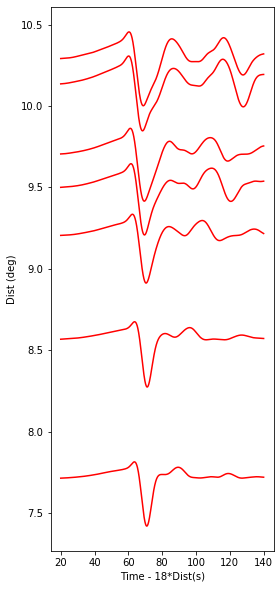

In [36]:
plt.figure(figsize=(4,10))
for net_sta in net_sta_list:
    to_plot,gcarc=process_single_data_trace_synthetic(net_sta,asdf_file_synthetic)
    to_plot=to_plot[2]
    print(np.max(to_plot.data))
    to_plot.normalize()
    x=np.linspace(20,to_plot.stats.endtime-to_plot.stats.starttime+20,to_plot.stats.npts)
    y=to_plot.data*(-0.3)+gcarc
    plt.plot(x,y,color="r")
    plt.xlabel("Time - 18*Dist(s)")
    plt.ylabel("Dist (deg)")

BO.WJM.S3.MXT | 2011-05-10T15:28:47.730632Z - 2011-05-10T15:30:47.730632Z | 10.0 Hz, 1201 samples
BO.WJM..BHT | 2011-05-10T15:28:47.700000Z - 2011-05-10T15:30:47.700000Z | 10.0 Hz, 1201 samples
BO.SRN.S3.MXT | 2011-05-10T15:29:03.130632Z - 2011-05-10T15:31:03.130632Z | 10.0 Hz, 1201 samples
BO.SRN..BHT | 2011-05-10T15:29:03.100000Z - 2011-05-10T15:31:03.100000Z | 10.0 Hz, 1201 samples
BO.KNM.S3.MXT | 2011-05-10T15:29:14.630632Z - 2011-05-10T15:31:14.630632Z | 10.0 Hz, 1201 samples
BO.KNM..BHT | 2011-05-10T15:29:14.600000Z - 2011-05-10T15:31:14.600000Z | 10.0 Hz, 1201 samples
BO.TTO.S3.MXT | 2011-05-10T15:29:19.930632Z - 2011-05-10T15:31:19.930632Z | 10.0 Hz, 1201 samples
BO.TTO..BHT | 2011-05-10T15:29:19.900000Z - 2011-05-10T15:31:19.900000Z | 10.0 Hz, 1201 samples
BO.NAA.S3.MXT | 2011-05-10T15:29:23.630632Z - 2011-05-10T15:31:23.630632Z | 10.0 Hz, 1201 samples
BO.NAA..BHT | 2011-05-10T15:29:23.700000Z - 2011-05-10T15:31:23.700000Z | 10.0 Hz, 1201 samples
BO.FUJ.S3.MXT | 2011-05-10T15:

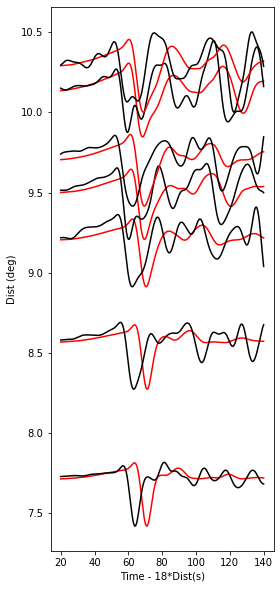

In [39]:
plt.figure(figsize=(4,10))
for net_sta in net_sta_list:
    to_plot,gcarc=process_single_data_trace_synthetic(net_sta,asdf_file_synthetic)
    to_plot_data,gcarc=process_single_data_trace(net_sta,asdf_file)
    to_plot=to_plot[2]
    to_plot_data=to_plot_data[0]
    to_plot.normalize()
    to_plot_data.normalize()
    x=np.linspace(20,to_plot.stats.endtime-to_plot.stats.starttime+20,to_plot.stats.npts)
    y=to_plot.data*(-0.3)+gcarc
    x_data=np.linspace(20,to_plot_data.stats.endtime-to_plot_data.stats.starttime+20,to_plot_data.stats.npts)
    y_data=to_plot_data.data*(-0.3)+gcarc
    plt.plot(x,y,color="r")
    plt.plot(x_data,y_data,color="k")
    plt.xlabel("Time - 18*Dist(s)")
    plt.ylabel("Dist (deg)")
    
    print(to_plot)
    print(to_plot_data)

In [40]:
asdf_file_EARA2014="/Users/ziyixi/work/Japan_Slab_code/data/asdf_files/compare_data_processing/sync_models/EARA2014_nosmooth_crust2.0_201105101526A.h5"

BO.WJM.S3.MXT | 2011-05-10T15:28:47.730632Z - 2011-05-10T15:30:47.730632Z | 10.0 Hz, 1201 samples
BO.WJM..BHT | 2011-05-10T15:28:47.700000Z - 2011-05-10T15:30:47.700000Z | 10.0 Hz, 1201 samples
BO.SRN.S3.MXT | 2011-05-10T15:29:03.130632Z - 2011-05-10T15:31:03.130632Z | 10.0 Hz, 1201 samples
BO.SRN..BHT | 2011-05-10T15:29:03.100000Z - 2011-05-10T15:31:03.100000Z | 10.0 Hz, 1201 samples
BO.KNM.S3.MXT | 2011-05-10T15:29:14.630632Z - 2011-05-10T15:31:14.630632Z | 10.0 Hz, 1201 samples
BO.KNM..BHT | 2011-05-10T15:29:14.600000Z - 2011-05-10T15:31:14.600000Z | 10.0 Hz, 1201 samples
BO.TTO.S3.MXT | 2011-05-10T15:29:19.930632Z - 2011-05-10T15:31:19.930632Z | 10.0 Hz, 1201 samples
BO.TTO..BHT | 2011-05-10T15:29:19.900000Z - 2011-05-10T15:31:19.900000Z | 10.0 Hz, 1201 samples
BO.NAA.S3.MXT | 2011-05-10T15:29:23.630632Z - 2011-05-10T15:31:23.630632Z | 10.0 Hz, 1201 samples
BO.NAA..BHT | 2011-05-10T15:29:23.700000Z - 2011-05-10T15:31:23.700000Z | 10.0 Hz, 1201 samples
BO.FUJ.S3.MXT | 2011-05-10T15:

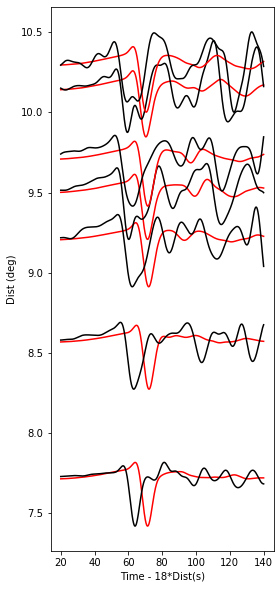

In [41]:
plt.figure(figsize=(4,10))
for net_sta in net_sta_list:
    to_plot,gcarc=process_single_data_trace_synthetic(net_sta,asdf_file_EARA2014)
    to_plot_data,gcarc=process_single_data_trace(net_sta,asdf_file)
    to_plot=to_plot[2]
    to_plot_data=to_plot_data[0]
    to_plot.normalize()
    to_plot_data.normalize()
    x=np.linspace(20,to_plot.stats.endtime-to_plot.stats.starttime+20,to_plot.stats.npts)
    y=to_plot.data*(-0.3)+gcarc
    x_data=np.linspace(20,to_plot_data.stats.endtime-to_plot_data.stats.starttime+20,to_plot_data.stats.npts)
    y_data=to_plot_data.data*(-0.3)+gcarc
    plt.plot(x,y,color="r")
    plt.plot(x_data,y_data,color="k")
    plt.xlabel("Time - 18*Dist(s)")
    plt.ylabel("Dist (deg)")
    
    print(to_plot)
    print(to_plot_data)

BO.WJM.S3.MXT | 2011-05-10T15:26:08.730632Z - 2011-05-10T15:36:08.730632Z | 10.0 Hz, 6001 samples
BO.WJM..BHT | 2011-05-10T15:26:08.800000Z - 2011-05-10T15:36:08.800000Z | 10.0 Hz, 6001 samples
BO.SRN.S3.MXT | 2011-05-10T15:26:08.730632Z - 2011-05-10T15:36:08.730632Z | 10.0 Hz, 6001 samples
BO.SRN..BHT | 2011-05-10T15:26:08.800000Z - 2011-05-10T15:36:08.800000Z | 10.0 Hz, 6001 samples
BO.KNM.S3.MXT | 2011-05-10T15:26:08.730632Z - 2011-05-10T15:36:08.730632Z | 10.0 Hz, 6001 samples
BO.KNM..BHT | 2011-05-10T15:26:08.800000Z - 2011-05-10T15:36:08.800000Z | 10.0 Hz, 6001 samples
BO.TTO.S3.MXT | 2011-05-10T15:26:08.730632Z - 2011-05-10T15:36:08.730632Z | 10.0 Hz, 6001 samples
BO.TTO..BHT | 2011-05-10T15:26:08.800000Z - 2011-05-10T15:36:08.800000Z | 10.0 Hz, 6001 samples
BO.NAA.S3.MXT | 2011-05-10T15:26:08.730632Z - 2011-05-10T15:36:08.730632Z | 10.0 Hz, 6001 samples
BO.NAA..BHT | 2011-05-10T15:26:08.800000Z - 2011-05-10T15:36:08.800000Z | 10.0 Hz, 6001 samples
BO.FUJ.S3.MXT | 2011-05-10T15:

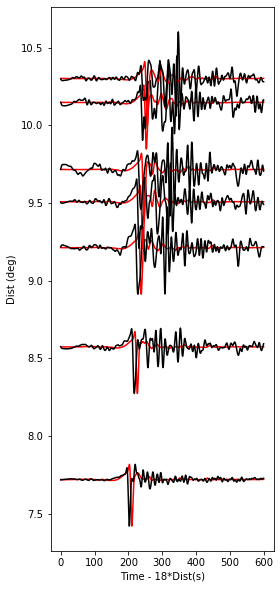

In [44]:
plt.figure(figsize=(4,10))
for net_sta in net_sta_list:
    to_plot,gcarc=process_single_data_trace_synthetic(net_sta,asdf_file_EARA2014)
    to_plot_data,gcarc=process_single_data_trace(net_sta,asdf_file)
    to_plot=to_plot[2]
    to_plot_data=to_plot_data[0]
    to_plot.normalize()
    to_plot_data.normalize()
    x=np.linspace(0,600,to_plot.stats.npts)
    y=to_plot.data*(-0.3)+gcarc
    x_data=np.linspace(0,600,to_plot_data.stats.npts)
    y_data=to_plot_data.data*(-0.3)+gcarc
    plt.plot(x,y,color="r")
    plt.plot(x_data,y_data,color="k")
    plt.xlabel("Time - 18*Dist(s)")
    plt.ylabel("Dist (deg)")
    
    print(to_plot)
    print(to_plot_data)

BO.WJM.S3.MXT | 2011-05-10T15:28:47.730632Z - 2011-05-10T15:30:47.730632Z | 10.0 Hz, 1201 samples
BO.WJM..BHT | 2011-05-10T15:28:47.700000Z - 2011-05-10T15:30:47.700000Z | 10.0 Hz, 1201 samples
BO.SRN.S3.MXT | 2011-05-10T15:29:03.130632Z - 2011-05-10T15:31:03.130632Z | 10.0 Hz, 1201 samples
BO.SRN..BHT | 2011-05-10T15:29:03.100000Z - 2011-05-10T15:31:03.100000Z | 10.0 Hz, 1201 samples
BO.KNM.S3.MXT | 2011-05-10T15:29:14.630632Z - 2011-05-10T15:31:14.630632Z | 10.0 Hz, 1201 samples
BO.KNM..BHT | 2011-05-10T15:29:14.600000Z - 2011-05-10T15:31:14.600000Z | 10.0 Hz, 1201 samples
BO.TTO.S3.MXT | 2011-05-10T15:29:19.930632Z - 2011-05-10T15:31:19.930632Z | 10.0 Hz, 1201 samples
BO.TTO..BHT | 2011-05-10T15:29:19.900000Z - 2011-05-10T15:31:19.900000Z | 10.0 Hz, 1201 samples
BO.NAA.S3.MXT | 2011-05-10T15:29:23.630632Z - 2011-05-10T15:31:23.630632Z | 10.0 Hz, 1201 samples
BO.NAA..BHT | 2011-05-10T15:29:23.700000Z - 2011-05-10T15:31:23.700000Z | 10.0 Hz, 1201 samples
BO.FUJ.S3.MXT | 2011-05-10T15:

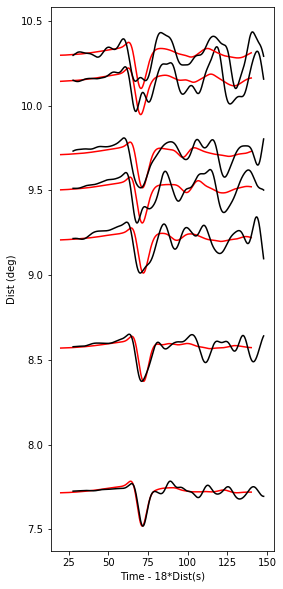

In [52]:
plt.figure(figsize=(4,10))
for net_sta in net_sta_list:
    to_plot,gcarc=process_single_data_trace_synthetic(net_sta,asdf_file_EARA2014)
    to_plot_data,gcarc=process_single_data_trace(net_sta,asdf_file)
    to_plot=to_plot[2]
    to_plot_data=to_plot_data[0]
    to_plot.normalize()
    to_plot_data.normalize()
    x=np.linspace(20,to_plot.stats.endtime-to_plot.stats.starttime+20,to_plot.stats.npts)
    y=to_plot.data*(-0.2)+gcarc
    x_data=np.linspace(20,to_plot_data.stats.endtime-to_plot_data.stats.starttime+20,to_plot_data.stats.npts)
    y_data=to_plot_data.data*(-0.2)+gcarc
    plt.plot(x,y,color="r")
    plt.plot(x_data+7.8,y_data,color="k")
    plt.xlabel("Time - 18*Dist(s)")
    plt.ylabel("Dist (deg)")
    
    print(to_plot)
    print(to_plot_data)

BO.WJM.S3.MXT | 2011-05-10T15:28:47.730632Z - 2011-05-10T15:30:47.730632Z | 10.0 Hz, 1201 samples
BO.WJM..BHT | 2011-05-10T15:28:47.700000Z - 2011-05-10T15:30:47.700000Z | 10.0 Hz, 1201 samples
BO.SRN.S3.MXT | 2011-05-10T15:29:03.130632Z - 2011-05-10T15:31:03.130632Z | 10.0 Hz, 1201 samples
BO.SRN..BHT | 2011-05-10T15:29:03.100000Z - 2011-05-10T15:31:03.100000Z | 10.0 Hz, 1201 samples
BO.KNM.S3.MXT | 2011-05-10T15:29:14.630632Z - 2011-05-10T15:31:14.630632Z | 10.0 Hz, 1201 samples
BO.KNM..BHT | 2011-05-10T15:29:14.600000Z - 2011-05-10T15:31:14.600000Z | 10.0 Hz, 1201 samples
BO.TTO.S3.MXT | 2011-05-10T15:29:19.930632Z - 2011-05-10T15:31:19.930632Z | 10.0 Hz, 1201 samples
BO.TTO..BHT | 2011-05-10T15:29:19.900000Z - 2011-05-10T15:31:19.900000Z | 10.0 Hz, 1201 samples
BO.NAA.S3.MXT | 2011-05-10T15:29:23.630632Z - 2011-05-10T15:31:23.630632Z | 10.0 Hz, 1201 samples
BO.NAA..BHT | 2011-05-10T15:29:23.700000Z - 2011-05-10T15:31:23.700000Z | 10.0 Hz, 1201 samples
BO.FUJ.S3.MXT | 2011-05-10T15:

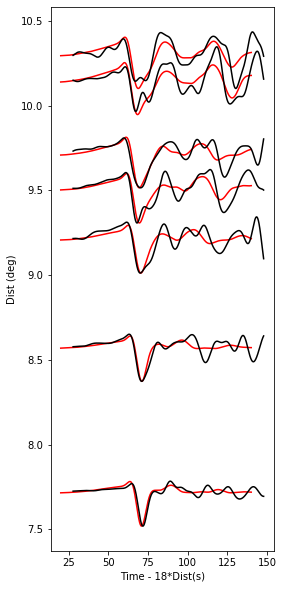

In [53]:
plt.figure(figsize=(4,10))
for net_sta in net_sta_list:
    to_plot,gcarc=process_single_data_trace_synthetic(net_sta,asdf_file_synthetic)
    to_plot_data,gcarc=process_single_data_trace(net_sta,asdf_file)
    to_plot=to_plot[2]
    to_plot_data=to_plot_data[0]
    to_plot.normalize()
    to_plot_data.normalize()
    x=np.linspace(20,to_plot.stats.endtime-to_plot.stats.starttime+20,to_plot.stats.npts)
    y=to_plot.data*(-0.2)+gcarc
    x_data=np.linspace(20,to_plot_data.stats.endtime-to_plot_data.stats.starttime+20,to_plot_data.stats.npts)
    y_data=to_plot_data.data*(-0.2)+gcarc
    plt.plot(x,y,color="r")
    plt.plot(x_data+7.8,y_data,color="k")
    plt.xlabel("Time - 18*Dist(s)")
    plt.ylabel("Dist (deg)")
    
    print(to_plot)
    print(to_plot_data)

BO.WJM.S3.MXT | 2011-05-10T15:28:47.730632Z - 2011-05-10T15:30:47.730632Z | 10.0 Hz, 1201 samples
BO.WJM..BHT | 2011-05-10T15:28:47.700000Z - 2011-05-10T15:30:47.700000Z | 10.0 Hz, 1201 samples
BO.SRN.S3.MXT | 2011-05-10T15:29:03.130632Z - 2011-05-10T15:31:03.130632Z | 10.0 Hz, 1201 samples
BO.SRN..BHT | 2011-05-10T15:29:03.100000Z - 2011-05-10T15:31:03.100000Z | 10.0 Hz, 1201 samples
BO.KNM.S3.MXT | 2011-05-10T15:29:14.630632Z - 2011-05-10T15:31:14.630632Z | 10.0 Hz, 1201 samples
BO.KNM..BHT | 2011-05-10T15:29:14.600000Z - 2011-05-10T15:31:14.600000Z | 10.0 Hz, 1201 samples
BO.TTO.S3.MXT | 2011-05-10T15:29:19.930632Z - 2011-05-10T15:31:19.930632Z | 10.0 Hz, 1201 samples
BO.TTO..BHT | 2011-05-10T15:29:19.900000Z - 2011-05-10T15:31:19.900000Z | 10.0 Hz, 1201 samples
BO.NAA.S3.MXT | 2011-05-10T15:29:23.630632Z - 2011-05-10T15:31:23.630632Z | 10.0 Hz, 1201 samples
BO.NAA..BHT | 2011-05-10T15:29:23.700000Z - 2011-05-10T15:31:23.700000Z | 10.0 Hz, 1201 samples
BO.FUJ.S3.MXT | 2011-05-10T15:

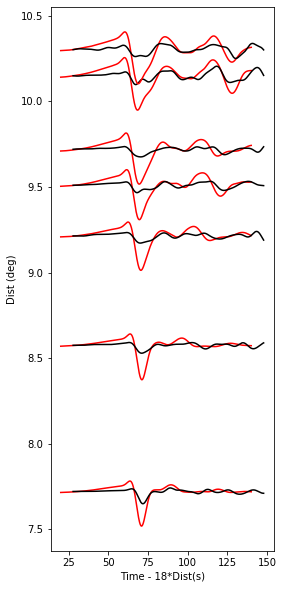

In [54]:
plt.figure(figsize=(4,10))
for net_sta in net_sta_list:
    to_plot,gcarc=process_single_data_trace_synthetic(net_sta,asdf_file_synthetic)
    to_plot_data,gcarc=process_single_data_trace(net_sta,asdf_file)
    to_plot=to_plot[2]
    to_plot_data=to_plot_data[0]
#     to_plot.normalize()
#     to_plot_data.normalize()
    (obspy.Stream()+to_plot+to_plot_data).normalize(global_max=True)
    x=np.linspace(20,to_plot.stats.endtime-to_plot.stats.starttime+20,to_plot.stats.npts)
    y=to_plot.data*(-0.2)+gcarc
    x_data=np.linspace(20,to_plot_data.stats.endtime-to_plot_data.stats.starttime+20,to_plot_data.stats.npts)
    y_data=to_plot_data.data*(-0.2)+gcarc
    plt.plot(x,y,color="r")
    plt.plot(x_data+7.8,y_data,color="k")
    plt.xlabel("Time - 18*Dist(s)")
    plt.ylabel("Dist (deg)")
    
    print(to_plot)
    print(to_plot_data)

## For the data, test different methods for processing.

In [55]:
def process_single_data_trace_thin_taper(net_sta,asdf_file):
    data=pyasdf.ASDFDataSet(asdf_file,mode="r")
    
    event = data.events[0]
    origin = event.preferred_origin() or event.origins[0]
    event_time = origin.time
    event_latitude = origin.latitude
    event_longitude = origin.longitude
    event_depth=origin.depth
    
    st=data.waveforms[net_sta].raw.copy()
    
    st.trim(event_time,event_time+1800)
    
    st.detrend("demean")
    st.detrend("linear")
    st.taper(max_percentage=0.05,type="hann")
    
    inv=data.waveforms[net_sta].StationXML
    
    max_period=100
    min_period=10
    f2 = 1.0 / max_period
    f3 = 1.0 / min_period
    f1 = 0.8 * f2
    f4 = 1.2 * f3
    pre_filt = (f1, f2, f3, f4)
    
    st.remove_response(output="DISP", pre_filt=pre_filt, zero_mean=False,
                               taper=False, inventory=inv, water_level=None)
    
    st.interpolate(sampling_rate=10)
    
    station_latitude = inv[0][0].latitude
    station_longitude = inv[0][0].longitude
    gcarc_m, baz, _ = gps2dist_azimuth(station_latitude, station_longitude,
                                             event_latitude, event_longitude)
    baz = np.mod(baz, 360)
    st.rotate(method="NE->RT", back_azimuth=baz)
    
#     st.filter("bandpass",freqmin=1/100,freqmax=1/10,corners=2,zerophase=True)
    
    to_plot=st.slice(event_time+kilometer2degrees(gcarc_m/1000)*18+20,event_time+kilometer2degrees(gcarc_m/1000)*18+140)
#     to_plot=st.slice(event_time,event_time+600)
    
    return to_plot,kilometer2degrees(gcarc_m/1000)

In [56]:
def process_single_data_trace_wide_taper(net_sta,asdf_file):
    data=pyasdf.ASDFDataSet(asdf_file,mode="r")
    
    event = data.events[0]
    origin = event.preferred_origin() or event.origins[0]
    event_time = origin.time
    event_latitude = origin.latitude
    event_longitude = origin.longitude
    event_depth=origin.depth
    
    st=data.waveforms[net_sta].raw.copy()
    
    st.trim(event_time,event_time+1800)
    
    st.detrend("demean")
    st.detrend("linear")
    st.taper(max_percentage=0.05,type="hann")
    
    inv=data.waveforms[net_sta].StationXML
    
    max_period=100
    min_period=10
    f2 = 1.0 / max_period
    f3 = 1.0 / min_period
    f1 = 0.5 * f2
    f4 = 2.0 * f3
    pre_filt = (f1, f2, f3, f4)
    
    st.remove_response(output="DISP", pre_filt=pre_filt, zero_mean=False,
                               taper=False, inventory=inv, water_level=None)
    
    st.interpolate(sampling_rate=10)
    
    station_latitude = inv[0][0].latitude
    station_longitude = inv[0][0].longitude
    gcarc_m, baz, _ = gps2dist_azimuth(station_latitude, station_longitude,
                                             event_latitude, event_longitude)
    baz = np.mod(baz, 360)
    st.rotate(method="NE->RT", back_azimuth=baz)
    
#     st.filter("bandpass",freqmin=1/100,freqmax=1/10,corners=2,zerophase=True)
    
    to_plot=st.slice(event_time+kilometer2degrees(gcarc_m/1000)*18+20,event_time+kilometer2degrees(gcarc_m/1000)*18+140)
#     to_plot=st.slice(event_time,event_time+600)
    
    return to_plot,kilometer2degrees(gcarc_m/1000)

In [ ]:
plt.figure(figsize=(4,10))
for net_sta in net_sta_list:
    to_plot,gcarc=process_single_data_trace_synthetic(net_sta,asdf_file_synthetic)
    to_plot_data,gcarc=process_single_data_trace(net_sta,asdf_file)
    to_plot=to_plot[2]
    to_plot_data=to_plot_data[0]
    to_plot.normalize()
    to_plot_data.normalize()
    x=np.linspace(20,to_plot.stats.endtime-to_plot.stats.starttime+20,to_plot.stats.npts)
    y=to_plot.data*(-0.2)+gcarc
    x_data=np.linspace(20,to_plot_data.stats.endtime-to_plot_data.stats.starttime+20,to_plot_data.stats.npts)
    y_data=to_plot_data.data*(-0.2)+gcarc
    plt.plot(x,y,color="r")
    plt.plot(x_data+7.8,y_data,color="k")
    plt.xlabel("Time - 18*Dist(s)")
    plt.ylabel("Dist (deg)")
    
    print(to_plot)
    print(to_plot_data)

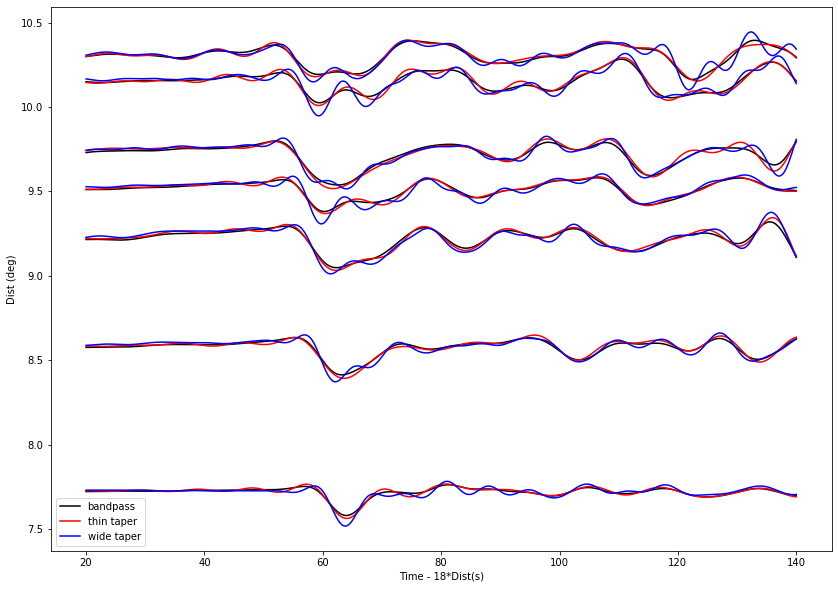

In [60]:
plt.figure(figsize=(14,10))
for net_sta in net_sta_list:
    to_plot_bandpass,gcarc=process_single_data_trace(net_sta,asdf_file)
    to_plot_bandpass=to_plot_bandpass[0]
    to_plot_thin_taper,_=process_single_data_trace_thin_taper(net_sta,asdf_file)
    to_plot_thin_taper=to_plot_thin_taper[0]
    to_plot_wide_taper,_=process_single_data_trace_wide_taper(net_sta,asdf_file)
    to_plot_wide_taper=to_plot_wide_taper[0]
    (obspy.Stream()+to_plot_bandpass+to_plot_thin_taper+to_plot_wide_taper).normalize(global_max=True)
    x=np.linspace(20,to_plot_bandpass.stats.endtime-to_plot_bandpass.stats.starttime+20,to_plot_bandpass.stats.npts)
    
    y_bandpass=to_plot_bandpass.data*(-0.2)+gcarc
    y_thin_taper=to_plot_thin_taper.data*(-0.2)+gcarc
    y_wide_taper=to_plot_wide_taper.data*(-0.2)+gcarc
    
    if(net_sta=="BO.WJM"):
        plt.plot(x,y_bandpass,color="k",label="bandpass")
        plt.plot(x,y_thin_taper,color="r",label="thin taper")
        plt.plot(x,y_wide_taper,color="b",label="wide taper")
    else:
        plt.plot(x,y_bandpass,color="k")
        plt.plot(x,y_thin_taper,color="r")
        plt.plot(x,y_wide_taper,color="b")        
    
    plt.xlabel("Time - 18*Dist(s)")
    plt.ylabel("Dist (deg)")
    plt.legend()